Masking the station and Predicting the target with Spatio-Temporal relations

In [127]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load CSV Data
df = pd.read_csv(r"E:\GNN\wind_filtered.csv")

# Normalize Features
scaler = MinMaxScaler()
df[['wind_speed', 'humidity', 'temperature', 'surface_pressure', 'Longitude', 'Latitude']] = scaler.fit_transform(
    df[['wind_speed', 'humidity', 'temperature', 'surface_pressure', 'Longitude', 'Latitude']]
)

# Define Graph Construction (KNN Approach)
def construct_graph(df, k=5, exclude_station=None):
    G = nx.Graph()
    stations = df[['Index', 'Longitude', 'Latitude']].drop_duplicates().reset_index(drop=True)

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(stations[['Longitude', 'Latitude']])
    distances, indices = nbrs.kneighbors(stations[['Longitude', 'Latitude']])
    
    for i, row in stations.iterrows():
        if row['Index'] == exclude_station:
            continue
        G.add_node(row['Index'], pos=(row['Longitude'], row['Latitude']))
        for j, dist in zip(indices[i], distances[i]):
            if row['Index'] != j and j != exclude_station:
                G.add_edge(row['Index'], j, weight=np.exp(-dist))
    
    return G

# Convert Graph to PyG Data
def graph_to_pyg(G, df, exclude_station=None, mask_station_features=False):
    edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    edge_weight = torch.tensor([G[u][v]['weight'] for u, v in G.edges()], dtype=torch.float32)

    # Remove masked station's features before training
    if exclude_station is not None:
        mask = df['Index'] != exclude_station
        features = torch.tensor(df.loc[mask, ['humidity', 'temperature', 'surface_pressure']].values, dtype=torch.float32)  
        targets = torch.tensor(df.loc[mask, 'wind_speed'].values, dtype=torch.float32).view(-1, 1)
    else:
        features = torch.tensor(df[['humidity', 'temperature', 'surface_pressure']].values, dtype=torch.float32)
        targets = torch.tensor(df['wind_speed'].values, dtype=torch.float32).view(-1, 1)

    if mask_station_features:
        mask = df['Index'] == exclude_station
        features[mask] = 0  # Replace features with zeros so only neighbors influence it

    return Data(x=features, edge_index=edge_index, edge_attr=edge_weight, y=targets)

# IGNNK with GRU Model Class
class IGNNK(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(IGNNK, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_weight):
        x = torch.relu(self.gcn1(x, edge_index, edge_weight))
        x = torch.relu(self.gcn2(x, edge_index, edge_weight))
        
        num_nodes = len(torch.unique(edge_index))  
        time_steps = x.shape[0] // num_nodes  

        x = x.view(num_nodes, time_steps, -1)  
        x, _ = self.gru(x)
        x = self.fc(x)  
        return x.view(-1, 1)  

# Training Function
def train_model(model, data, epochs=1000, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.edge_attr)
        loss = criterion(output, data.y)  
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}")
    
    return model

# Evaluate Model on Unseen Node
def evaluate(model, data, masked_index):
    model.eval()
    
    with torch.no_grad():
        predictions = model(data.x, data.edge_index, data.edge_attr)

    # Get masked station data
    station_mask = np.where(df['Index'] == masked_index)[0]
    
    if station_mask.size == 0 or station_mask[0] >= predictions.shape[0]:
        raise ValueError(f"Masked station index {masked_index} not found in predictions.")

    masked_preds = predictions[station_mask].cpu().numpy()
    ground_truth = data.y[station_mask].cpu().numpy()
    
    # Compute Evaluation Metrics
    mae = mean_absolute_error(ground_truth, masked_preds)
    rmse = np.sqrt(mean_squared_error(ground_truth, masked_preds))
    r2 = r2_score(ground_truth, masked_preds)
    
    print(f"Evaluation Metrics for Masked Station:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    return masked_preds

# Mask One Station for Inductive Learning
masked_station = 2  
G_train = construct_graph(df, k=5, exclude_station=masked_station)
data_train = graph_to_pyg(G_train, df, exclude_station=masked_station)


model = IGNNK(input_dim=3, hidden_dim=64, output_dim=1)
model = train_model(model, data_train, epochs=1000)

# Introduce the Masked Station (WITHOUT Retraining) & Predict
G_test = construct_graph(df, k=5)  
data_test = graph_to_pyg(G_test, df, mask_station_features=True)  

# Evaluate on Masked Station
predictions = evaluate(model, data_test, masked_station)
print("Predictions for masked station (all timestamps):", predictions)


Epoch 0: Loss = 0.1504383683204651
Epoch 10: Loss = 0.02335844561457634
Epoch 20: Loss = 0.022528916597366333
Epoch 30: Loss = 0.021840518340468407
Epoch 40: Loss = 0.021397221833467484
Epoch 50: Loss = 0.02111317589879036
Epoch 60: Loss = 0.020914336666464806
Epoch 70: Loss = 0.020398637279868126
Epoch 80: Loss = 0.020406479015946388
Epoch 90: Loss = 0.020481642335653305
Epoch 100: Loss = 0.01977713592350483
Epoch 110: Loss = 0.0193964671343565
Epoch 120: Loss = 0.01940067671239376
Epoch 130: Loss = 0.019090775400400162
Epoch 140: Loss = 0.01894492655992508
Epoch 150: Loss = 0.019367512315511703
Epoch 160: Loss = 0.018745766952633858
Epoch 170: Loss = 0.02508687600493431
Epoch 180: Loss = 0.01948458142578602
Epoch 190: Loss = 0.01837276853621006
Epoch 200: Loss = 0.01709721051156521
Epoch 210: Loss = 0.018915442749857903
Epoch 220: Loss = 0.019347064197063446
Epoch 230: Loss = 0.018069671466946602
Epoch 240: Loss = 0.016175204887986183
Epoch 250: Loss = 0.026772132143378258
Epoch 260:

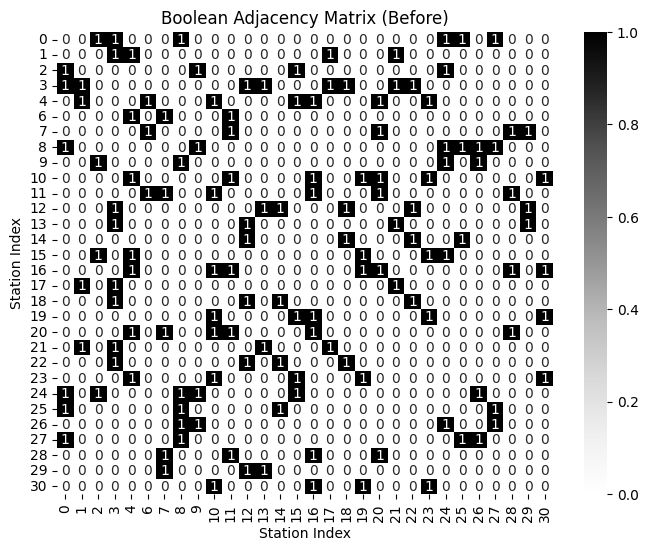

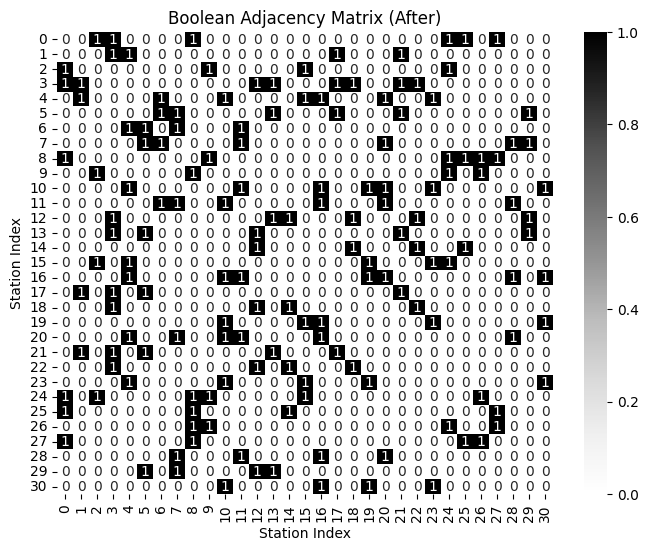

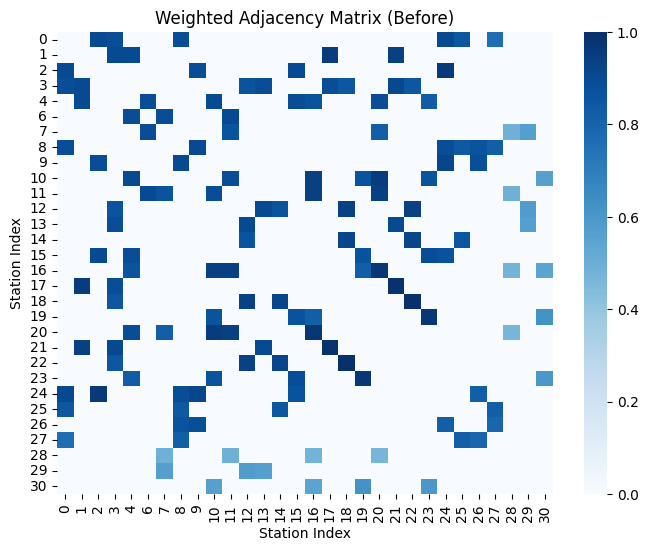

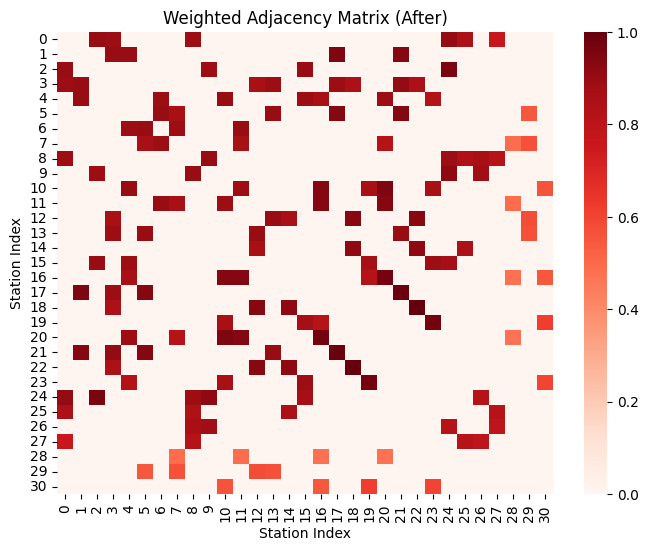

In [119]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def compute_adjacency_matrices(G):
    """Computes Boolean and weighted adjacency matrices with integer station indices."""
    nodes = sorted(list(G.nodes))  # Sort nodes by index (ensures consistency)
    num_nodes = len(nodes)

    # Create empty matrices
    bool_adj_matrix = np.zeros((num_nodes, num_nodes), dtype=int)  # Boolean adjacency
    weighted_adj_matrix = np.zeros((num_nodes, num_nodes))  # Weighted adjacency

    # Populate adjacency matrices
    for i, node1 in enumerate(nodes):
        for j, node2 in enumerate(nodes):
            if G.has_edge(node1, node2):
                bool_adj_matrix[i, j] = 1  # Binary connection
                weighted_adj_matrix[i, j] = round(G[node1][node2]['weight'], 2)  # Store edge weight (rounded)

    return bool_adj_matrix, weighted_adj_matrix, nodes

def plot_adjacency_matrix(adj_matrix, nodes, title, cmap="Blues", fmt="d", annot=False):
    """Plots an adjacency matrix as a heatmap with proper integer station labels."""
    plt.figure(figsize=(8, 6))
    
    # Ensure integer labels
    int_nodes = list(map(int, nodes))
    
    # Plot heatmap
    sns.heatmap(adj_matrix, annot=annot, fmt=fmt, cmap=cmap, xticklabels=int_nodes, yticklabels=int_nodes)
    
    plt.xlabel("Station Index")
    plt.ylabel("Station Index")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# Step 1: Compute Adjacency Matrices BEFORE adding the masked station
G_train = construct_graph(df, k=5, exclude_station=masked_station)
bool_adj_before, weighted_adj_before, nodes_before = compute_adjacency_matrices(G_train)

# Step 2: Compute Adjacency Matrices AFTER adding the masked station
G_test = construct_graph(df, k=5)  # Includes the masked station now
bool_adj_after, weighted_adj_after, nodes_after = compute_adjacency_matrices(G_test)

# Plot Boolean Adjacency Matrices (Binary)
plot_adjacency_matrix(bool_adj_before, nodes_before, "Boolean Adjacency Matrix (Before)", cmap="Greys", fmt="d", annot=True)
plot_adjacency_matrix(bool_adj_after, nodes_after, "Boolean Adjacency Matrix (After)", cmap="Greys", fmt="d", annot=True)

# Plot Weighted Adjacency Matrices (With Edge Weights)
plot_adjacency_matrix(weighted_adj_before, nodes_before, "Weighted Adjacency Matrix (Before)", cmap="Blues", fmt=".2f", annot=False)
plot_adjacency_matrix(weighted_adj_after, nodes_after, "Weighted Adjacency Matrix (After)", cmap="Reds", fmt=".2f", annot=False)



In [123]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random

# Load CSV Data
df = pd.read_csv(r"E:\GNN\wind_filtered.csv")

# Normalize Features
scaler = MinMaxScaler()
df[['wind_speed', 'humidity', 'temperature', 'surface_pressure', 'Longitude', 'Latitude']] = scaler.fit_transform(
    df[['wind_speed', 'humidity', 'temperature', 'surface_pressure', 'Longitude', 'Latitude']]
)

def construct_graph(df, k=5, exclude_station=None, edge_dropout=0.2):
    G = nx.Graph()
    stations = df[['Index', 'Longitude', 'Latitude']].drop_duplicates().reset_index(drop=True)
    
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(stations[['Longitude', 'Latitude']])
    distances, indices = nbrs.kneighbors(stations[['Longitude', 'Latitude']])
    
    for i, row in stations.iterrows():
        if row['Index'] == exclude_station:
            continue
        G.add_node(row['Index'], pos=(row['Longitude'], row['Latitude']))
        for j, dist in zip(indices[i], distances[i]):
            if row['Index'] != j and j != exclude_station:
                G.add_edge(row['Index'], j, weight=np.exp(-dist))
    
    edges = list(G.edges)
    num_edges_to_remove = int(len(edges) * edge_dropout)
    removed_edges = random.sample(edges, num_edges_to_remove)
    G.remove_edges_from(removed_edges)
    
    return G

def sample_subgraph(G, sample_size=10):
    sampled_nodes = random.sample(list(G.nodes), min(sample_size, len(G.nodes)))
    return G.subgraph(sampled_nodes).copy()

def graph_to_pyg(G, df, exclude_station=None, mask_station_features=False):
    edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    edge_weight = torch.tensor([G[u][v]['weight'] for u, v in G.edges()], dtype=torch.float32)
    
    mask = df['Index'] != exclude_station
    features = torch.tensor(df.loc[mask, ['humidity', 'temperature', 'surface_pressure']].values, dtype=torch.float32)
    targets = torch.tensor(df.loc[mask, 'wind_speed'].values, dtype=torch.float32).view(-1, 1)
    
    if mask_station_features:
        mask = df['Index'] == exclude_station
        features[mask] = 0  
    
    return Data(x=features, edge_index=edge_index, edge_attr=edge_weight, y=targets)

class IGNNK(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(IGNNK, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_weight):
        x = torch.relu(self.gcn1(x, edge_index, edge_weight))
        x = torch.relu(self.gcn2(x, edge_index, edge_weight))
        x, _ = self.gru(x.unsqueeze(0))
        x = self.fc(x.squeeze(0))
        return x

def train_model(model, data, epochs=1000, lr=0.01, subgraph_sampling=True, sample_size=10):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        if subgraph_sampling:
            sampled_G = sample_subgraph(G_train, sample_size=sample_size)
            data_sampled = graph_to_pyg(sampled_G, df)
            output = model(data_sampled.x, data_sampled.edge_index, data_sampled.edge_attr)
            loss = criterion(output, data_sampled.y)
        else:
            output = model(data.x, data.edge_index, data.edge_attr)
            loss = criterion(output, data.y)
        
        loss.backward()
        optimizer.step()
        
        if epoch % 1 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}")
    
    return model

def evaluate(model, data, masked_index):
    model.eval()
    with torch.no_grad():
        predictions = model(data.x, data.edge_index, data.edge_attr)
    
    station_mask = np.where(df['Index'] == masked_index)[0]
    if station_mask.size == 0 or station_mask[0] >= predictions.shape[0]:
        raise ValueError(f"Masked station index {masked_index} not found in predictions.")
    
    masked_preds = predictions[station_mask].cpu().numpy()
    ground_truth = data.y[station_mask].cpu().numpy()
    
    mae = mean_absolute_error(ground_truth, masked_preds)
    rmse = np.sqrt(mean_squared_error(ground_truth, masked_preds))
    r2 = r2_score(ground_truth, masked_preds)
    
    print(f"Evaluation Metrics for Masked Station:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    return masked_preds

masked_station = 5  
G_train = construct_graph(df, k=5, exclude_station=masked_station, edge_dropout=0.2)
data_train = graph_to_pyg(G_train, df, exclude_station=masked_station)

model = IGNNK(input_dim=3, hidden_dim=64, output_dim=1)
model = train_model(model, data_train, epochs=1000, subgraph_sampling=True, sample_size=15)

G_test = construct_graph(df, k=5, edge_dropout=0.2)  
data_test = graph_to_pyg(G_test, df, mask_station_features=True)  

predictions = evaluate(model, data_test, masked_station)
print("Predictions for masked station (all timestamps):", predictions)


Epoch 0: Loss = 0.23304739594459534
Epoch 1: Loss = 0.02303529530763626
Epoch 2: Loss = 0.19982093572616577
Epoch 3: Loss = 0.023396024480462074
Epoch 4: Loss = 0.05447699874639511
Epoch 5: Loss = 0.0814613550901413
Epoch 6: Loss = 0.08201494067907333
Epoch 7: Loss = 0.06896945089101791
Epoch 8: Loss = 0.05130466818809509
Epoch 9: Loss = 0.03447096422314644
Epoch 10: Loss = 0.02416357956826687
Epoch 11: Loss = 0.02497543953359127
Epoch 12: Loss = 0.034356337040662766
Epoch 13: Loss = 0.03896261006593704
Epoch 14: Loss = 0.03359775245189667
Epoch 15: Loss = 0.0258894395083189
Epoch 16: Loss = 0.023100925609469414
Epoch 17: Loss = 0.025711117312312126
Epoch 18: Loss = 0.029185647144913673
Epoch 19: Loss = 0.030128931626677513
Epoch 20: Loss = 0.028514165431261063
Epoch 21: Loss = 0.02583473175764084
Epoch 22: Loss = 0.02372121997177601
Epoch 23: Loss = 0.023103507235646248
Epoch 24: Loss = 0.023855959996581078
Epoch 25: Loss = 0.025004925206303596
Epoch 26: Loss = 0.025452662259340286
Ep